# xarray-spatial 介绍

本文主要参考[Xarray-spatial documentation](https://xarray-spatial.org/)，了解 Xarray-spatial部分方法，以快速地在本地执行栅格GIS计算。

栅格是规则栅格化的数据集，例如GeoTIFF，JPG和PNG。

在GIS世界中，栅格用于表示连续现象（例如，海拔，降雨量，距离），可以直接将其表示为数值，也可以将其表示为供人类查看的RGB图像。栅格通常具有两个空间维度，但可以具有任意数量的其他维度（时间，测量类型等）。

在Python生态系统中，许多地理空间库与GDAL C ++库设有接口，以进行栅格和矢量的输入，输出和分析（例如rasterio，rasterstats，geopandas）。GDAL健壮，高效，且在其诞生后已进行了数十年出色工作。多年来，以这种方式使耗时的计算达到 C/C++ 级别一直是Python库的关键性能策略（很显然，Python本身是用C实现的！）。

但是，包装GDAL对于Python开发人员和数据科学家来说有一些缺点：

- GDAL很难构建/安装。
- GDAL对于Python开发人员/分析者来说很难扩展，因为它需要理解多种语言。
- GDAL的数据结构是在 C/C++ 层面定义的，这限制了如何从Python访问它们。

随着诸如Numba之类项目的引入，Python获得了直接在Python中提供高性能代码的新方法，而无需依赖于单独的 C/C ++扩展 或受其限制。xarray-spatial正是使用Numba和Dask实现算法，使其所有源代码都可以作为纯Python使用，而没有任何“黑匣子”障碍，以前这些掩盖了正在发生的事情的障碍阻止了性能全面优化。我们可以在xarray-spatial可用的地方使用其提供的功能，而在需要其他任务的地方仍然可以使用GDAL。

下面是xarray-spatial的依赖情况：

![](pictures/dependencies.svg)

- 根据官方文档介绍，xarray-spatial源自Datashader项目，当前也仍依赖于Datashader，该项目提供了用于xarray-spatial的矢量数据（点，线，多边形，网格和栅格）的快速栅格化。但很快将被更新为仅依赖于xarray和numba，同时仍然能够在可用时利用Datashader输出。
- Xarray-Spatial使用Numba实现了常见的栅格分析功能，并提供了易于安装，易于扩展的代码库来进行栅格分析。
- Xarray-Spatial 还可以通过 Dask 扩展。

xarray-spatial 支持的运算有哪些可以参考 其[github主页](https://github.com/makepath/xarray-spatial#supported-spatial-functions-with-supported-inputs)

下面简单记录zonal分析做示例。

-----

Xarray-spatial的 zonal 函数提供一种简单的方法来生成栅格聚合区域的统计信息。它包括一组默认的计算集合，或者可以输入任何想要执行的自定义计算。

- [Generate terrain](#Generate-Terrain-Data)
- [Zonal Statistics](#Zonal-Statistics)

-----------


引入numpy和一些来自datashader的函数来轻松渲染图像作为例子的开端。

In [1]:
import numpy as np
import pandas as pd

import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

## Generate Terrain Data

下面的地理相关函数侧重于栅格数据。为了演示如何使用这些基于栅格的函数，首先使用xarray-spatial的generate terrain 来生成一个假的高程地形栅格。我们使用datashader的Canvas作为一个快速基础来建立一个新的栅格。

先补充一些 generate terrain 相关函数的说明。主要参考：[makepath/xarray-spatial/examples/user_guide/1_Surface.ipynb](https://github.com/makepath/xarray-spatial/blob/master/examples/user_guide/1_Surface.ipynb)

generate terrain 相关函数来自 xarray-spatial 的 Surface 部分。使用Surface工具，可以量化和可视化由数字高程模型表示的地形地貌。从用Xarray DataArray表示的栅格面开始，这些工具可以帮助识别一些在原始表面中可能不容易看到的特定模式。每个函数的返回一个Xarray DataArray。surface工具主要有以下函数：

- Hillshade:通过考虑光源角度和阴影，从表面栅格创建一个阴影浮雕。
- slope:标识栅格的每个单元格的斜度。
- curvature:计算栅格表面的曲率
- Aspect:生成栅格表面每个单元格的Aspect。
- Viewshed:从一个可选的观察者高度的视角确定输入栅格表面的可见位置。

这里主要就用到了Hillshade，其他的暂时没用到。Datashader的Canvas对象提供了一个方便的框架来建立一个新的栅格，所以我们将使用我们的“生成地形”函数来生成一些假地形作为一个高程栅格。一旦我们有了这个，我们将使用datashader的阴影来方便可视化。

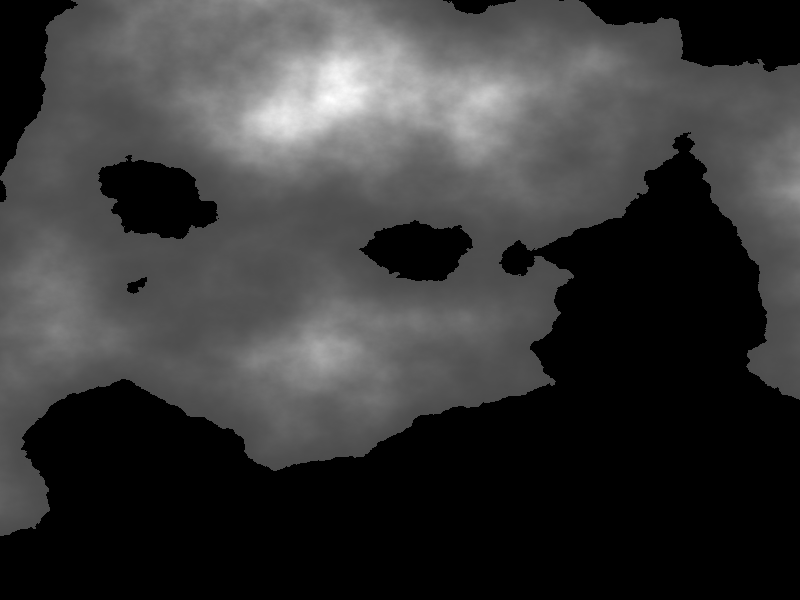

In [2]:
from xrspatial import generate_terrain

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20e6, 20e6), y_range=(-20e6, 20e6))
terrain = generate_terrain(canvas=cvs)

shade(terrain, cmap=['black', 'white'], how='linear')

In [3]:
type(terrain)

xarray.core.dataarray.DataArray

上图中的灰度值显示了高程，按从黑到白的颜色强度线性缩放(大的黑色区域表示低高程)。如果我们将最低的值映射到代表水的颜色上，将最高的值映射到代表山顶的颜色上，它看起来就会更像一个景观。让我们试试上面导入的Elevation colormap

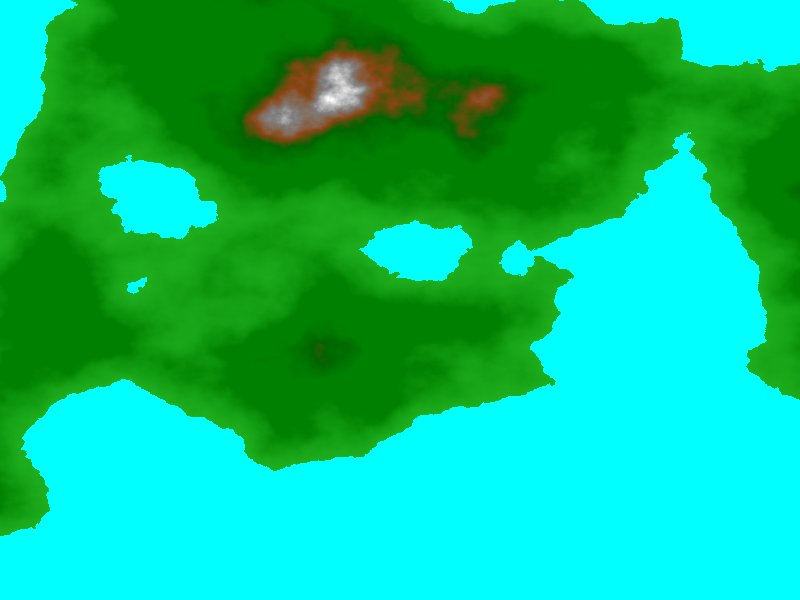

In [4]:
shade(terrain, cmap=Elevation, how='linear')

## Zonal Statistics

Zonal statistics使用 xarray.DataArray 计算特定区域，即zone，的汇总统计信息。通过创建具有相同形状的相应聚合，并将每个单元格的值设置为表示唯一区域id的唯一非零整数，可以定义聚合中的特定区域。

例如，如果我们设置第一行所有值为聚合对象，设置其值为3，那么zone统计将在最上面一行计算聚合值并返回 zone\#3 结果。

zone stats 的输出是pandas DataFrame形式，每个zone对应一行。

比如要进行为期六天的徒步旅行。

- 可以用地形栅格来表示这个区域。
- 在这个地形中，可以用一条线段来表示从起点到终点的每一天的路径。
- 可以使用包含起始点和结束点的pandas数据帧进行设置，然后用Canvas.line将其聚合。

下面看看在上面假的地形上的 line zones

用到了[Hillshade](https://en.wikipedia.org/wiki/Terrain_cartography)，如前所述，这是一种使用假想光源照亮地形，从而将地形可视化为阴影浮雕的技术。每个单元的照度值由其对光源的方向决定，该方向可以从坡度和角度计算。

让我们将Hillshade应用到我们的地形中，并使用阴影来可视化结果。

注意 shade，stack都是datashader中的可视化函数。

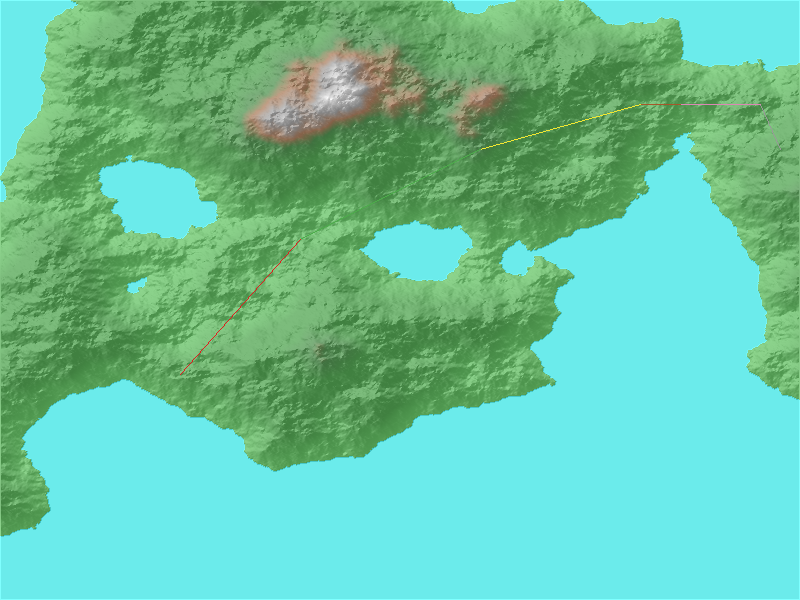

In [5]:
from xrspatial import hillshade
from datashader.colors import Set1

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20, 20), y_range=(-20, 20))

terrain = generate_terrain(canvas=cvs)
terrain_shaded = shade(terrain, cmap=Elevation, alpha=128, how='linear')

illuminated = hillshade(terrain)
illuminated_shaded = shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear')

zone_df = pd.DataFrame({
   'x': [-11, -5, 4, 12, 14, 18, 19],
   'y': [-5, 4, 10, 13, 13, 13, 10],
   'trail_segement_id': [11, 12, 13, 14, 15, 16, 17]
})

zones_agg = cvs.line(zone_df, 'x', 'y', ds.sum('trail_segement_id'))
zones_shaded = dynspread(shade(zones_agg, cmap=Set1), max_px=5)

stack(illuminated_shaded, terrain_shaded, zones_shaded)

In [6]:
zones_agg

<xarray.DataArray (y: 600, x: 800)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 -19.98 -19.93 -19.88 -19.82 ... 19.82 19.88 19.93 19.98
  * y        (y) float64 -19.97 -19.9 -19.83 -19.77 ... 19.77 19.83 19.9 19.97

现在，快速纠正nan值之后，应用区域统计。

In [7]:
from xrspatial import zonal_stats
zones_agg.values = np.nan_to_num(zones_agg.values, copy=False).astype(int)
zonal_stats(zones_agg, terrain)

,zone,mean,max,min,sum,std,var,count
0,0,887.687779,4000.000000,0.000000,4.255211e+08,872.639188,761499.152736,479359
1,11,1321.919879,1428.384240,1228.065037,1.797811e+05,53.409131,2852.535316,136
2,12,1489.600166,2399.556289,1220.694206,2.681280e+05,310.177594,96210.140061,180
3,13,1711.632114,2430.430303,1368.922124,2.738611e+05,278.369664,77489.669636,160
4,14,1355.661087,1368.952389,1346.856316,5.422644e+04,6.249734,39.059170,40
5,15,1381.950485,1443.856734,1319.891060,1.105560e+05,38.918956,1514.685125,80
6,16,1486.314866,1709.222348,1367.673562,6.688417e+04,120.950684,14629.068060,45


#### 计算每个区域的自定义统计数据

也可以加入我们自己的统计计算集合来代替上面的默认计算。

- 将所需的函数设置到一个字典，并将其作为' zonal stats '的第三个参数输入。
- 下面，尝试一个范围函数，一个最小函数，一个最大函数。

In [8]:
custom_stats = dict(elevation_change=lambda zone: zone.max() - zone.min(),
                    elevation_min=np.min,
                    elevation_max=np.max)

zonal_stats(zones_agg, terrain, custom_stats)

,zone,elevation_change,elevation_min,elevation_max
0,0,4000.000000,0.000000,4000.000000
1,11,200.319203,1228.065037,1428.384240
2,12,1178.862083,1220.694206,2399.556289
3,13,1061.508179,1368.922124,2430.430303
4,14,22.096073,1346.856316,1368.952389
5,15,123.965674,1319.891060,1443.856734
6,16,341.548786,1367.673562,1709.222348


这里的区域是由线段定义的，但是它们可以是任何空间模式，或者更具体地说，任何可以作为Datashader聚合计算的区域。

zonal_stats 详细的介绍，请参考[这里](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.stats.html#xrspatial.zonal.stats)。